In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob

# Load csv data into a dataframe
# df = pd.read_csv('chile_news_2019_10_01_to_2019_11_01_with_link.csv')
df = pd.read_csv('tweets_with_long_urls.csv') # Read in previously lengthened urls
print(df.shape)
df.head()

(36698, 6)


,Unnamed: 0,User,TweetCreated,TweetId,Link,Contents
0,0,meganoticiascl,2019-10-31T23:37:59.000Z,1190050315481100293,https://twitter.com/meganoticiascl/status/1190...,Manifestantes con disfraces se toman la marcha...
1,1,meganoticiascl,2019-10-31T23:06:40.000Z,1190042433117024256,https://twitter.com/meganoticiascl/status/1190...,🔴 LO ÚLTIMO: Ahora varias manifestaciones a lo...
2,2,meganoticiascl,2019-10-31T23:03:55.000Z,1190041740457250816,https://twitter.com/meganoticiascl/status/1190...,"Marcelo Salas y movilizaciones sociales: ""Lo q..."
3,3,meganoticiascl,2019-10-31T22:38:04.000Z,1190035237050474497,https://twitter.com/meganoticiascl/status/1190...,Nueva jornada de masivas marchas en Santiago y...
4,4,meganoticiascl,2019-10-31T22:21:32.000Z,1190031075885690881,https://twitter.com/meganoticiascl/status/1190...,Sismo afecta a la zona central del país\n\nhtt...


In [2]:
import pandas as pd
import re
from unshortenit import UnshortenIt
from cachetools import cached, LRUCache
from tqdm import tqdm

# This uses a regex from stackoverflow: https://stackoverflow.com/a/48769624

# Regex Explained:
# (?:(?:https?|ftp):\/\/)?: Matches the start of a URL (http, https, or ftp followed by ://), but this part is optional.
# [\w/\-?=%.]+: Matches the domain name and may include parts of the path. It accepts letters, numbers, underscores, slashes, hyphens, question marks, equal signs, percent signs, and dots.
# \.: Matches a literal dot, typically preceding the top-level domain.
# [\w/\-&?=%.]+: Matches the top-level domain and can include additional path or query parameters, allowing letters, numbers, underscores, slashes, hyphens, ampersands, question marks, equal signs, percent signs, and dots.
regex_pattern = r'https?://\S+'

unshortener = UnshortenIt()

@cached(LRUCache(maxsize=40_000))
def unshorten_url(url):
    """
    Expands a shortened URL to its original form, using caching to improve efficiency.

    This function uses the UnshortenIt library to expand shortened URLs (e.g., 't.co' links).
    The results are cached in an LRU (Least Recently Used) cache to optimize performance for
    repeated requests of the same URL.

    Args:
    - url (str): The shortened URL to be expanded.

    Returns:
    - str: The original, expanded URL. If unshortening fails, returns the original shortened URL.

    The cache can store up to 10,000 entries. When the cache's capacity is reached, the least recently
    used entries are discarded to make space for new ones.
    """
    try:
        return unshortener.unshorten(url)
    except Exception as e:
        print(f"Error unshortening URL {url}: {e}")
        return url

def replace_shortened_urls(text):
    """
    Replaces all shortened URLs found in the given text with their unshortened forms.

    Parameters:
    - text (str): Text containing one or more shortened URLs.

    Returns:
    - str: Text with all shortened URLs replaced by unshortened ones.
    """
    urls = re.findall(regex_pattern, text)
    for url in urls:
        unshortened_url = unshorten_url(url)

        if url == unshortened_url:
            # print(f"URL {url} could not be shortened.")
            pass
            
        else:
            # print(f"URL {url} shortened to {unshortened_url}")
            text = text.replace(url, unshortened_url)
    return text

import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def unshorten_urls_in_contents(df, max_workers=100):
    """
    Applies replace_shortened_urls to the 'Contents' column of a DataFrame using multithreading
    for improved performance and displays a detailed progress bar.

    Parameters:
    - df (pd.DataFrame): DataFrame with the 'Contents' text column containing shortened URLs.
    - max_workers (int): Maximum number of threads to use for processing.

    Returns:
    - pd.DataFrame: DataFrame with URLs in the 'Contents' replaced by their unshortened forms
                    in the new 'Contents_Short_Url' col.
    """
    # Function to apply to each row
    def process_row(row):
        return replace_shortened_urls(row.Contents)

    # Initialize the ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submitting tasks to the executor
        futures = {executor.submit(process_row, row): i for i, row in enumerate(df.itertuples())}

        # Progress bar setup and processing
        for future in tqdm(as_completed(futures), total=len(df), desc="Unshortening URLs", unit="row"):
            index = futures[future]
            try:
                # Retrieve the result and update the DataFrame
                df.at[index, 'Contents_Short_Url'] = future.result()
            except Exception as e:
                print(f"Error processing row {index}: {e}")

    return df

In [3]:
# Comment out as ths was run 
# df_long_urls = unshorten_urls_in_contents(df)
# df_long_urls.to_csv("tweets_with_long_urls.csv", index=False)
# df = df_long_urls
# df.Contents[30_000]

In [4]:
df

,Unnamed: 0,User,TweetCreated,TweetId,Link,Contents
0,0,meganoticiascl,2019-10-31T23:37:59.000Z,1190050315481100293,https://twitter.com/meganoticiascl/status/1190...,Manifestantes con disfraces se toman la marcha...
1,1,meganoticiascl,2019-10-31T23:06:40.000Z,1190042433117024256,https://twitter.com/meganoticiascl/status/1190...,🔴 LO ÚLTIMO: Ahora varias manifestaciones a lo...
2,2,meganoticiascl,2019-10-31T23:03:55.000Z,1190041740457250816,https://twitter.com/meganoticiascl/status/1190...,"Marcelo Salas y movilizaciones sociales: ""Lo q..."
3,3,meganoticiascl,2019-10-31T22:38:04.000Z,1190035237050474497,https://twitter.com/meganoticiascl/status/1190...,Nueva jornada de masivas marchas en Santiago y...
4,4,meganoticiascl,2019-10-31T22:21:32.000Z,1190031075885690881,https://twitter.com/meganoticiascl/status/1190...,Sismo afecta a la zona central del país\n\nhtt...
...,...,...,...,...,...,...
36693,36693,T13,2019-09-30T21:37:07.000Z,1178785874751971337,https://twitter.com/T13/status/117878587475197...,"Qué es el ""fraude del CEO"" con el que hackers ..."
36694,36694,T13,2019-09-30T21:27:52.000Z,1178783544186937344,https://twitter.com/T13/status/117878354418693...,EN VIVO 🥇 | Comienzan los 200 metros femeninos...
36695,36695,T13,2019-09-30T21:27:18.000Z,1178783400536236033,https://twitter.com/T13/status/117878340053623...,Centro Sismológico explica últimos temblores r...
36696,36696,T13,2019-09-30T21:17:22.000Z,1178780901670604802,https://twitter.com/T13/status/117878090167060...,EN VIVO 🥇 | Arrancan los 3 mil metros con obst...


# URLs

## Look at top URLs in the tweets

In [10]:
df["Contents"][0]

'Manifestantes con disfraces se toman la marcha en Plaza Italia\n\nhttps://www.meganoticias.cl/nacional/280814-fotos-manifestantes-disfraces-halloween-marcha-plaza-italia.html'

In [6]:
import pandas as pd
import re

def create_url_dataframe(df, input_col="Contents", output_col="URL"):
    """
    Creates a new DataFrame by extracting and exploding URLs from a specified column.

    This function uses a regex to identify and extract URLs from text in the specified input column.
    Extracted URLs are placed in a new column, and the DataFrame is expanded so that each URL 
    has its own row while retaining associated data.

    Parameters:
    - df (pd.DataFrame): DataFrame with text data.
    - input_col (str): Name of the column containing text with URLs. Default is 'Contents'.
    - output_col (str): Name of the new column to store extracted URLs. Default is 'URL'.

    Returns:
    - pd.DataFrame: A new DataFrame with original columns and an additional column for extracted URLs.
    """
    # Function to extract URLs from text
    def extract_urls(text):
        return re.findall(r'https?://\S+', text)

    # Extract URLs and explode into separate rows
    df[output_col] = df[input_col].apply(extract_urls)
    url_df = df.explode(output_col)

    return url_df

# Usage example
df_url = create_url_dataframe(df)
print(df_url.head())


KeyError: 'Contents_Long_Url'

In [ ]:
# Look at the 20 most common urls
df_url['URL'].value_counts().head(20)

URL
https://t.co/7NAh4DtN8O                                                                                                                                            873
https://www.meganoticias.cl/                                                                                                                                       767
https://www.t13.cl/en-vivo                                                                                                                                         642
https://www.cooperativa.cl/radioenvivo/                                                                                                                            284
https://edition.cnn.com/                                                                                                                                           282
https://cooperativa.cl/radioenvivo/                                                                                                                              

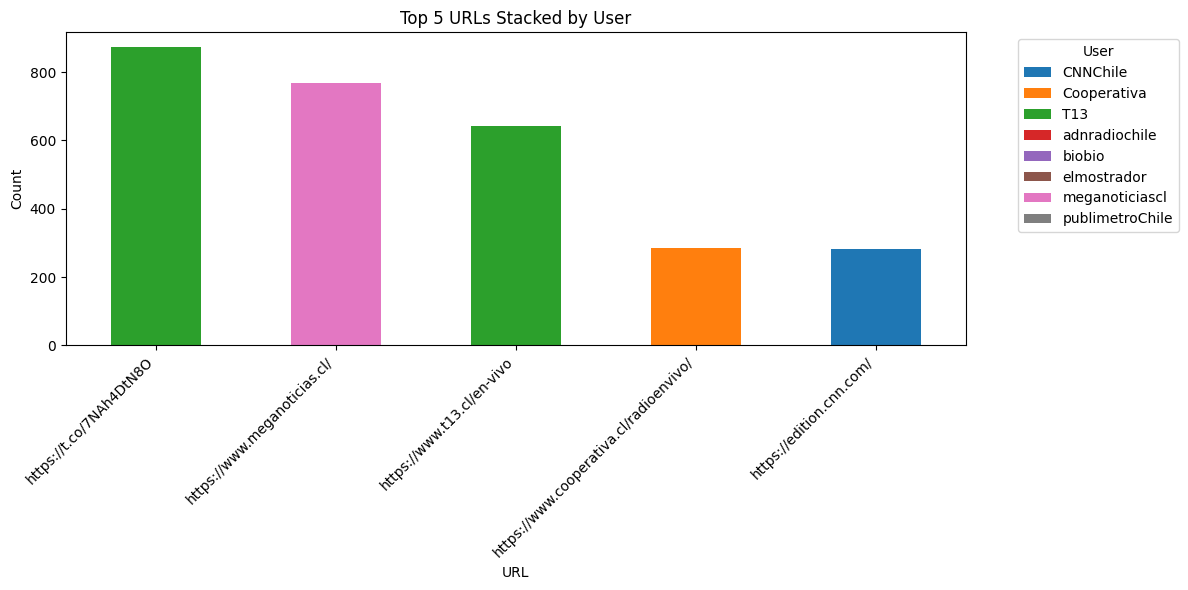

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_stacked_bar_chart(df, num_urls=5):
    """
    Plots a stacked bar chart of the most popular URLs, grouped by user.
    
    Parameters:
    - df: DataFrame with 'User' and 'URL' columns.
    - num_urls: Number of top URLs to display.
    """
    # Aggregate data
    url_counts = df.groupby(['URL', 'User']).size().unstack(fill_value=0)
    
    # Get the top N URLs
    top_urls = url_counts.sum(axis=1).nlargest(num_urls).index

    # Filter data for top URLs
    top_url_data = url_counts.loc[top_urls]

    # Plot
    top_url_data.plot(kind='bar', stacked=True, figsize=(12, 6))
    
    plt.title(f'Top {num_urls} URLs Stacked by User')
    plt.ylabel('Count')
    plt.xlabel('URL')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='User', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    plt.show()

plot_stacked_bar_chart(df_url)


In [ ]:
def display_url_presence_by_user(url_df):
    binary_table = pd.crosstab(url_df['URL'], url_df['User'])
    binary_table[binary_table > 0] = 1
    return binary_table

# Usage:
url_user_presence = display_url_presence_by_user(df_url)
url_user_presence.to_csv("url_presence_table.csv")
url_user_presence

User,CNNChile,Cooperativa,T13,adnradiochile,biobio,elmostrador,meganoticiascl,publimetroChile
URL,,,,,,,,
http://goleadorhistorico.alairelibre.cl/,0,1,0,0,0,0,0,0
http://jugadordelafecha.alairelibre.cl/,0,1,0,0,0,0,0,0
http://programas.cooperativa.cl/loquequedadeldia/,0,1,0,0,0,0,0,0
http://programas.cooperativa.cl/showalairelibre/,0,1,0,0,0,0,0,0
http://programas.cooperativa.cl/unanuevamanana/#primercafe,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
https://www.youtube.com/watch?v=wn4NnrcVH1A,0,0,0,1,0,0,0,0
https://www.youtube.com/watch?v=xETTy0FJ1Nk,0,0,0,1,0,0,0,0
https://www.youtube.com/watch?v=y5vvZ5gbF10,1,0,0,0,0,0,0,0


In [ ]:
def display_url_presence_by_user(df):
    """
    Displays a table with binary indicators showing whether a user has tweeted a URL.
    
    Parameters:
    - df: DataFrame with 'User' and 'URL' columns.
    """
    # Ensure 'URL' is a string
    df['URL'] = df['URL'].astype(str)

    binary_table = pd.crosstab(df['URL'], df['User'])
    binary_table[binary_table > 0] = 1
    return binary_table

# Usage:
url_user_presence = display_url_presence_by_user(df_url)
url_user_presence


User,CNNChile,Cooperativa,T13,adnradiochile,biobio,elmostrador,meganoticiascl,publimetroChile
URL,,,,,,,,
http://goleadorhistorico.alairelibre.cl/,0,1,0,0,0,0,0,0
http://jugadordelafecha.alairelibre.cl/,0,1,0,0,0,0,0,0
http://programas.cooperativa.cl/loquequedadeldia/,0,1,0,0,0,0,0,0
http://programas.cooperativa.cl/showalairelibre/,0,1,0,0,0,0,0,0
http://programas.cooperativa.cl/unanuevamanana/#primercafe,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
https://www.youtube.com/watch?v=xETTy0FJ1Nk,0,0,0,1,0,0,0,0
https://www.youtube.com/watch?v=y5vvZ5gbF10,1,0,0,0,0,0,0,0
https://www.youtube.com/watch?v=yElajfrBzOc,0,0,0,1,0,0,0,0


In [ ]:
# Filter rows where the sum across columns is at least min_user_count
url_user_presence[url_user_presence.sum(axis=1) > 1]

User,CNNChile,Cooperativa,T13,adnradiochile,biobio,elmostrador,meganoticiascl,publimetroChile
URL,,,,,,,,
https://twitter.com/Ejercito_Chile/status/1185667934410215424,0,0,1,1,0,0,0,0
https://twitter.com/Transantiago/status/1187495812726738949,0,1,0,0,0,0,1,0
https://twitter.com/UOCT_RM/status/1187750224682504192,0,0,1,0,1,0,0,0
nan,1,1,1,1,1,1,1,1


/tmp/ipykernel_14972/1997819645.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


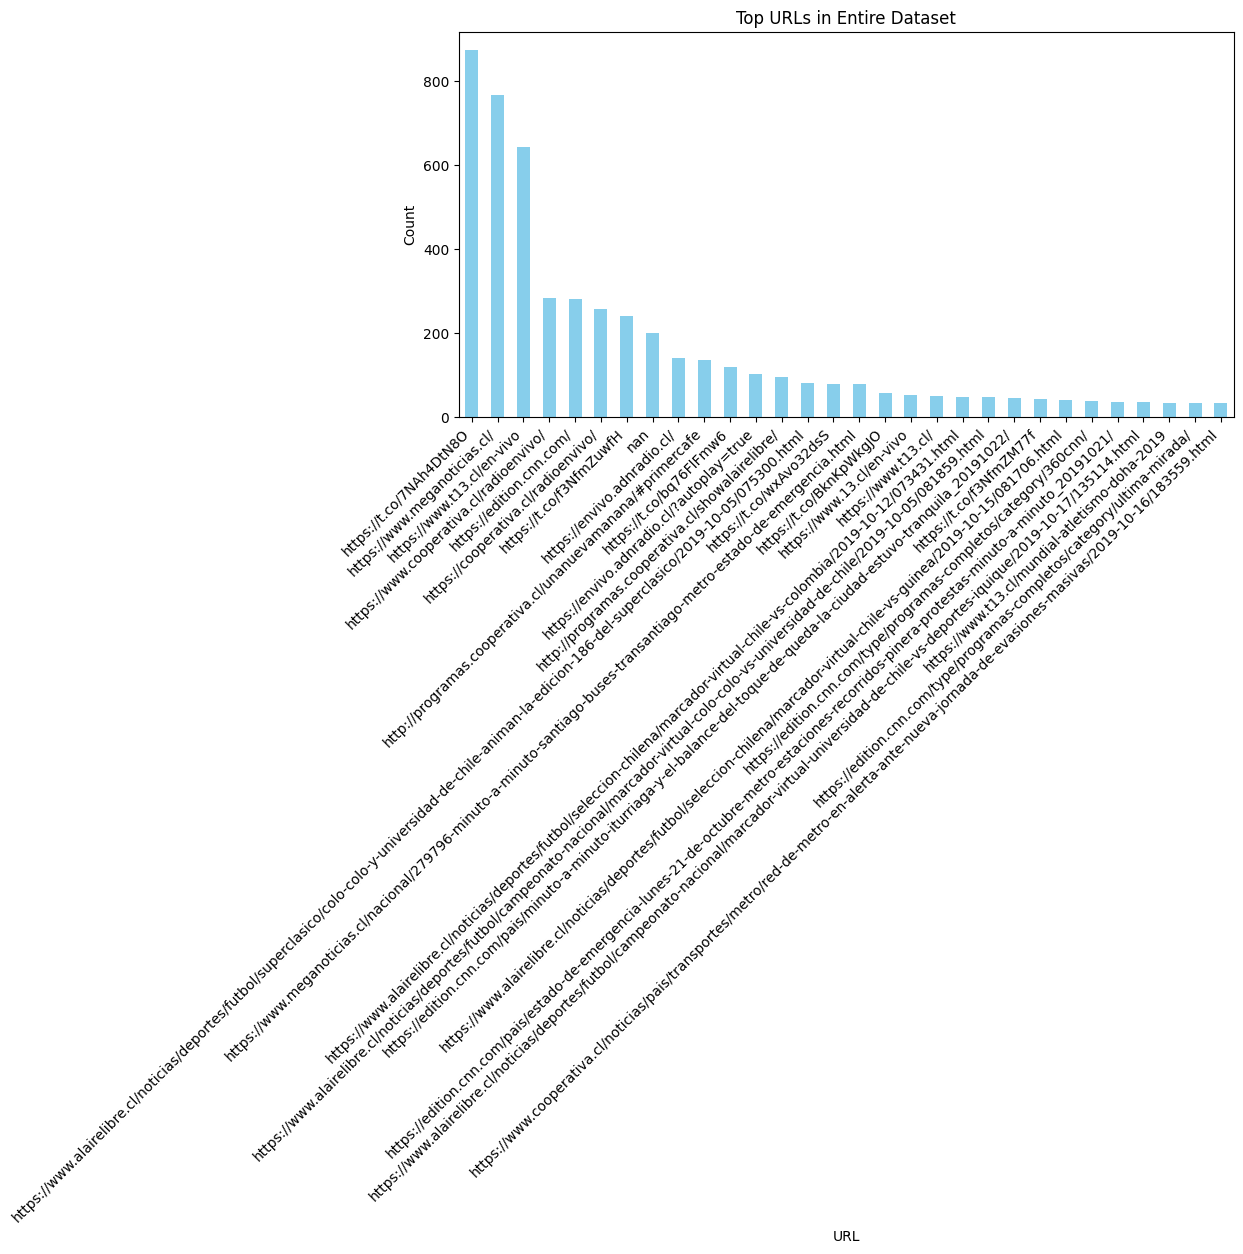

In [ ]:
def plot_total_url_counts(url_df, num_urls=30):
    """
    Plots the top URLs in the entire dataset.
    
    Parameters:
    - url_df: DataFrame with 'URLs' column.
    - num_urls: Number of top URLs to display.
    """
    plt.figure(figsize=(10, 5))
    url_df['URL'].value_counts().head(num_urls).plot(kind='bar', color='skyblue')
    plt.title('Top URLs in Entire Dataset')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_total_url_counts(df_url)

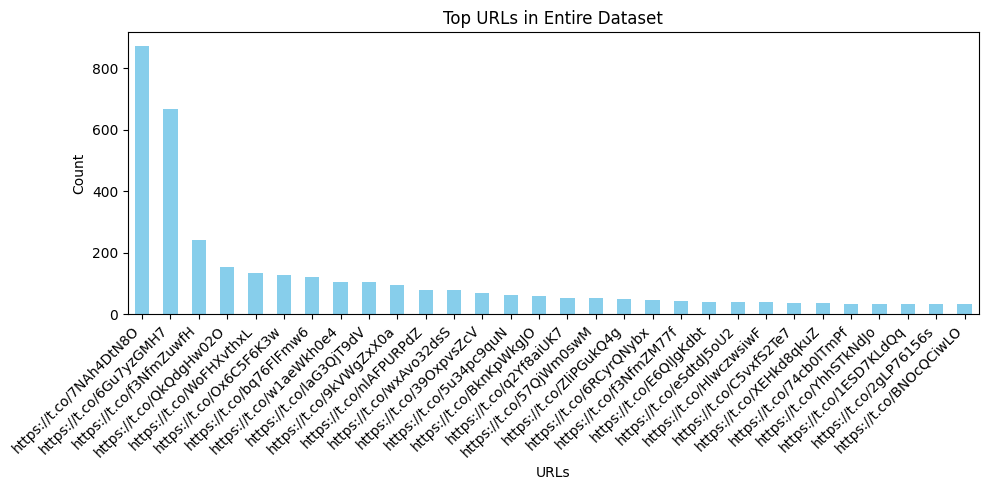

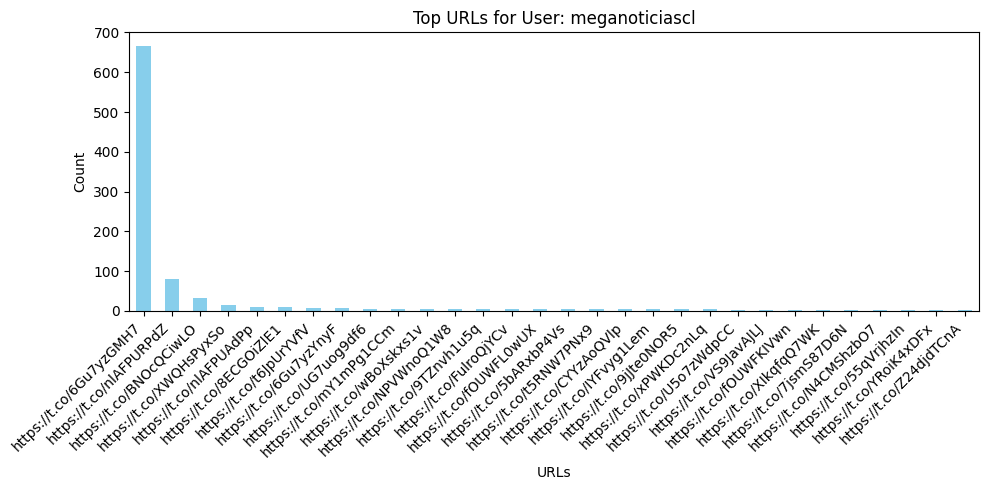

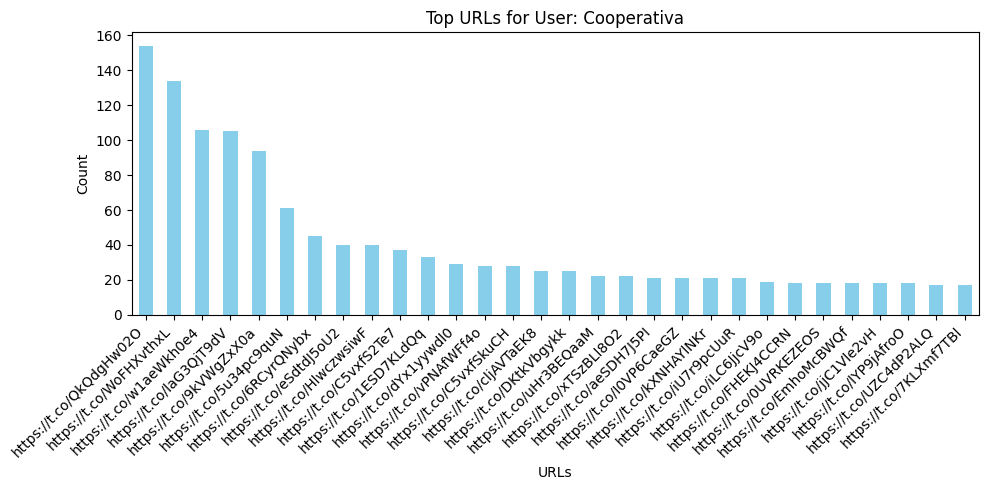

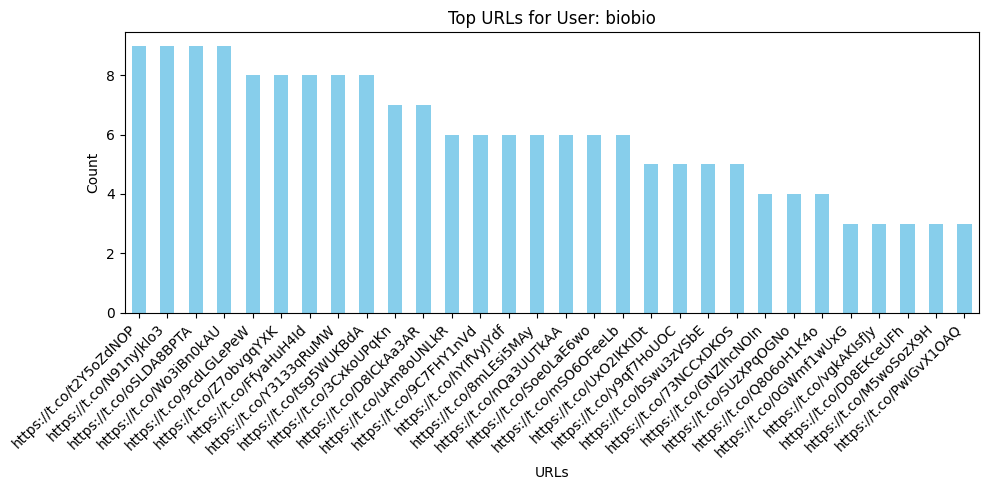

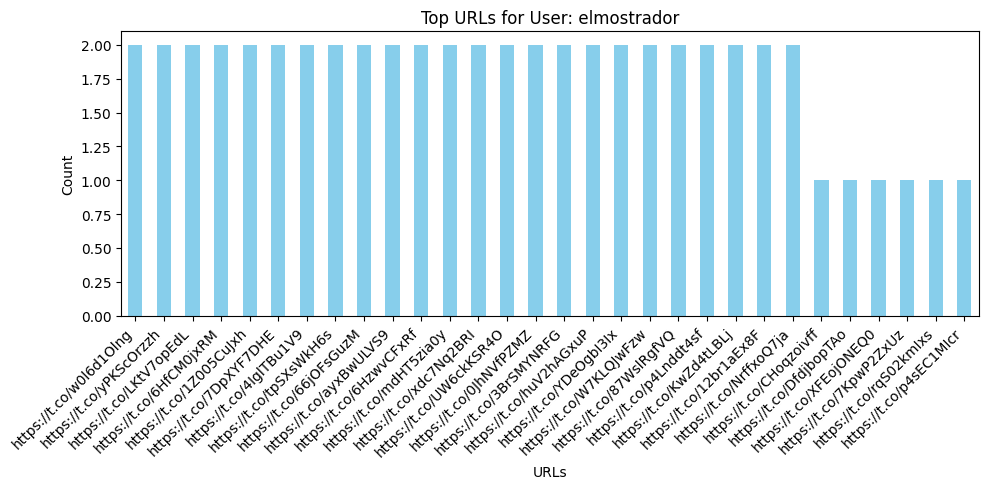

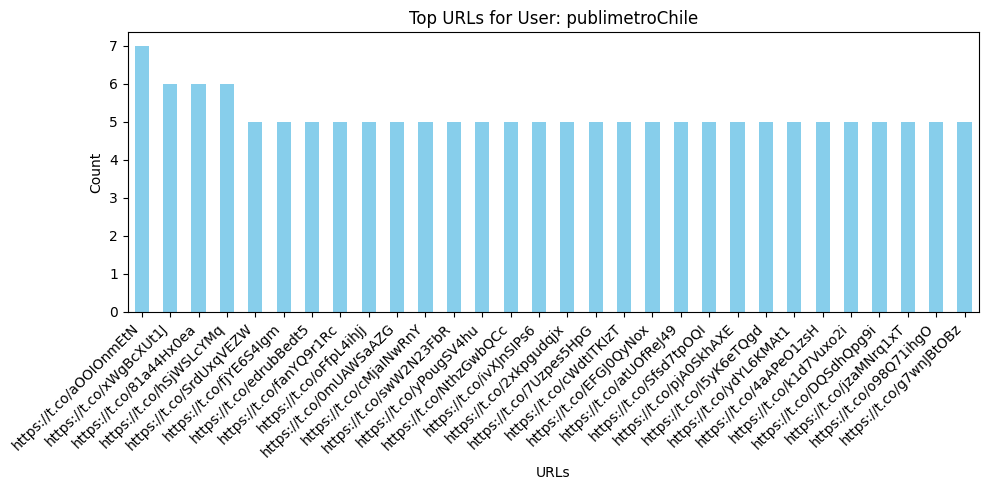

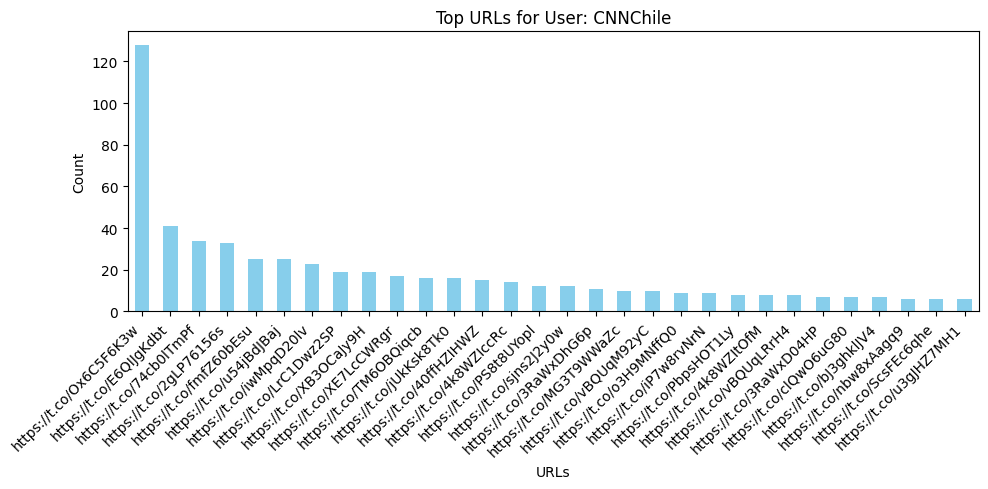

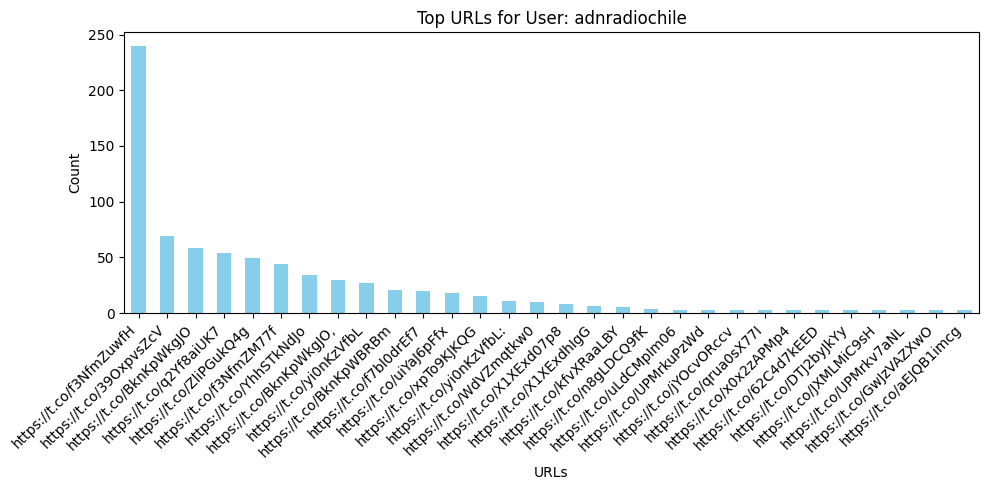

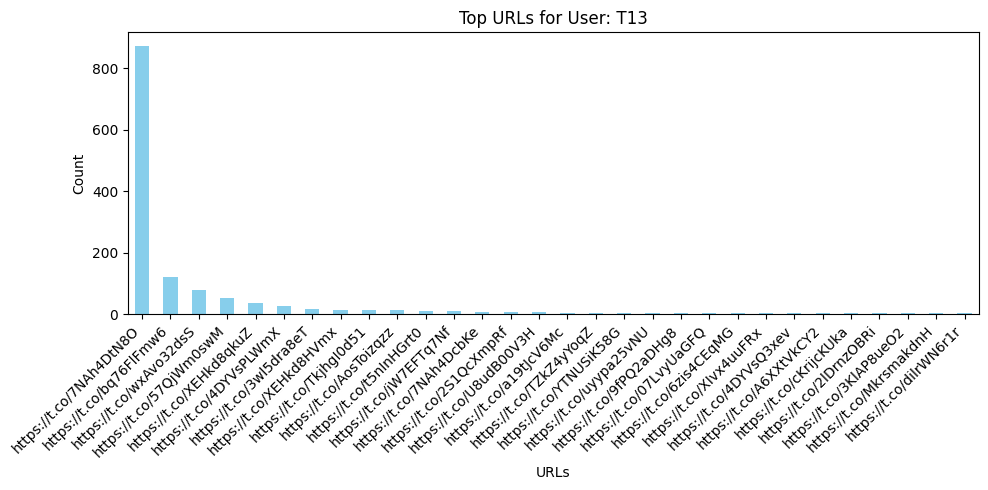

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re

def plot_top_urls(df, num_urls=5):
    """
    Plots the top URLs in the 'Contents' column of the dataframe, both for the entire dataset and per user.
    
    Parameters:
    - df: DataFrame with a 'Contents' column containing text and a 'User' column for user names.
    - num_urls: Number of top URLs to display.
    """
    
    # Function to extract URLs from text
    def extract_urls(text):
        return re.findall(r'(https?://\S+)', text)

    # Extract URLs and explode into separate rows
    df['URLs'] = df['Contents'].apply(extract_urls)
    url_data = df.explode('URLs')

    # Plot for the entire dataset
    plt.figure(figsize=(10, 5))
    url_data['URLs'].value_counts().head(num_urls).plot(kind='bar', color='skyblue')
    plt.title('Top URLs in Entire Dataset')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Plot for each user
    for user in df['User'].unique():
        plt.figure(figsize=(10, 5))
        user_data = url_data[url_data['User'] == user]
        user_data['URLs'].value_counts().head(num_urls).plot(kind='bar', color='skyblue')
        plt.title(f'Top URLs for User: {user}')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

plot_top_urls(df, num_urls=30)
